#Installing Pyspark

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=27473edf44efe74caac7869429f58da7ae616580a6cb1402167073124b3ab661
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


#Importing libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Creating spark session

In [ ]:
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()

# Loading the Dataset

In [ ]:
dataset_path = "Healthcare_dataset.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [ ]:
df

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int]

# Checking for null values in the DataFrame

In [ ]:
from pyspark.sql.functions import col
null_columns = [col(column) for column in df.columns if df.filter(col(column).isNull()).count() > 0]
if null_columns:
    print("Warning: There are null values in the following columns:")
    for column in null_columns:
        print(column)
else:
    print("No null values in the dataset.")

No null values in the dataset.


#Data Preprocessing

## Converting categorical columns to numerical representations

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
smoking_indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_index")

## One-hot encoding the indexed categorical columns

In [ ]:
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")
smoking_encoder = OneHotEncoder(inputCol="smoking_index", outputCol="smoking_encoded")

## Assembling all features into a single vector

In [ ]:
feature_columns = ["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level",
                   "gender_encoded", "smoking_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
# Create a pipeline for preprocessing
preprocessing_pipeline = Pipeline(stages=[gender_indexer, smoking_indexer, gender_encoder, smoking_encoder, assembler, scaler])
# Fit and transform the data
preprocessed_data = preprocessing_pipeline.fit(df).transform(df)

# Visualizations

# Pairplot Visualization

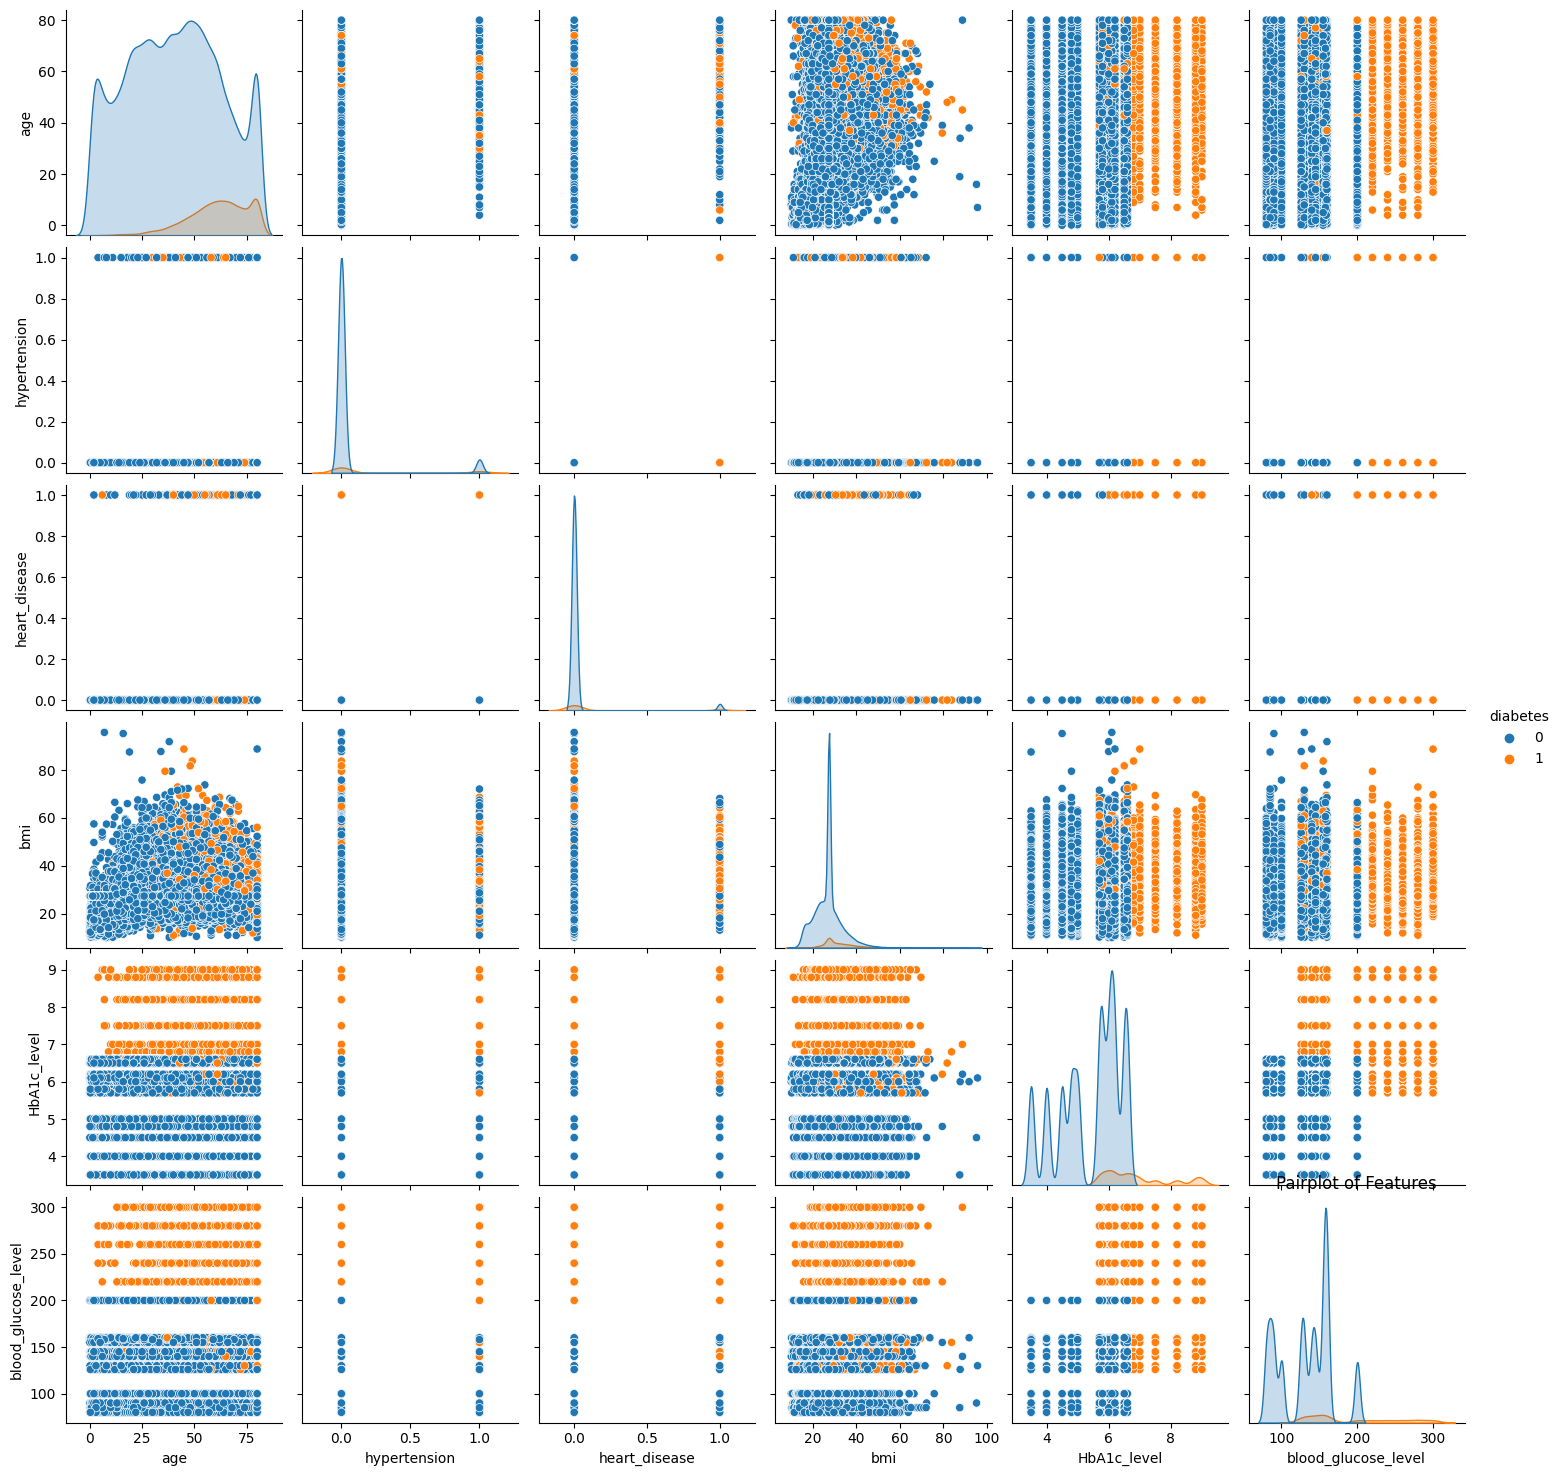

In [ ]:
target_column = 'diabetes'
feature_columns_without_features = [col for col in feature_columns if col != 'features']
pandas_df = preprocessed_data.select(feature_columns_without_features + [target_column]).toPandas()
sns.pairplot(pandas_df, hue=target_column)
plt.title("Pairplot of Features")
plt.show()

# Visualization of Correlation Matrix

<ipython-input-12-9afe8a4c55d5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = pandas_df.corr()


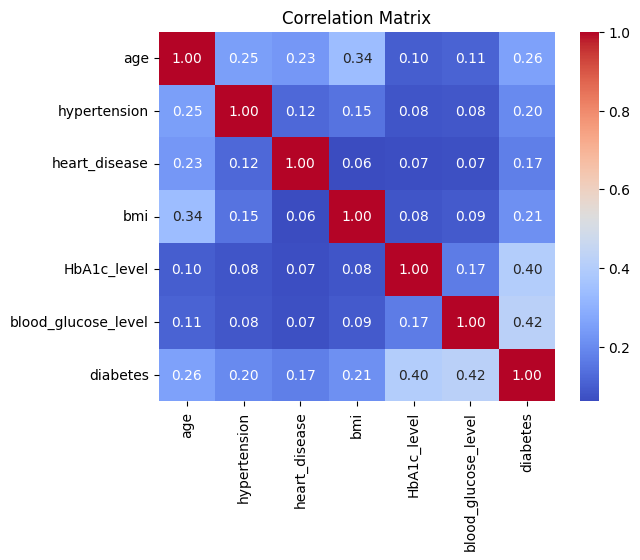

In [ ]:
corr_matrix = pandas_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


# Visualization of Bar Plot of Target Variable Distribution

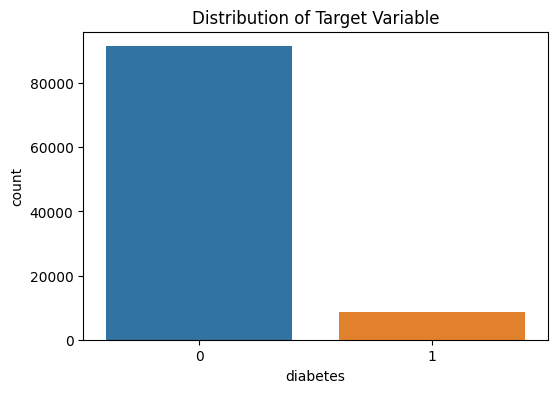

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, data=pandas_df)
plt.title("Distribution of Target Variable")
plt.show()


# Visualization of Box Plot of Age by Target Variable

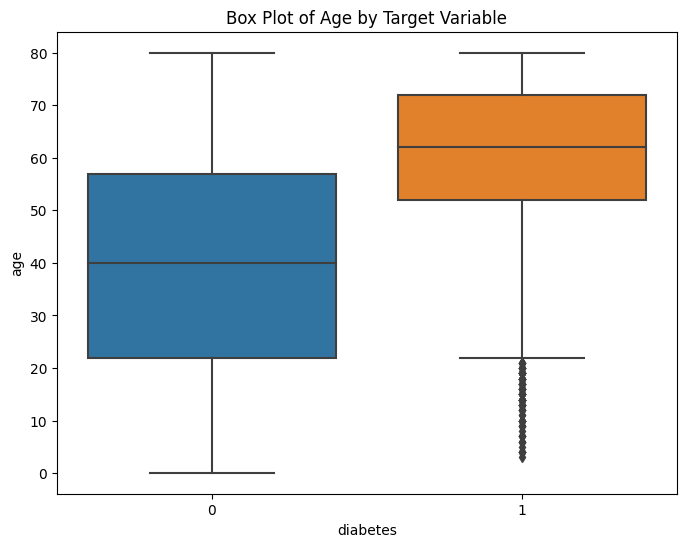

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=target_column, y='age', data=pandas_df)
plt.title("Box Plot of Age by Target Variable")
plt.show()


# Visualization of Distribution of BMI by Target Variable

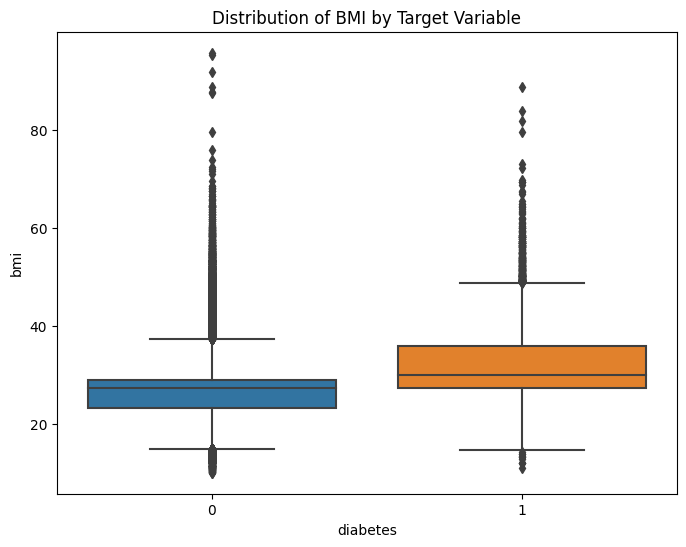

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=target_column, y='bmi', data=pandas_df)
plt.title("Distribution of BMI by Target Variable")
plt.show()


# Visualization of Blood Glucose Level Distribution by Target Variable

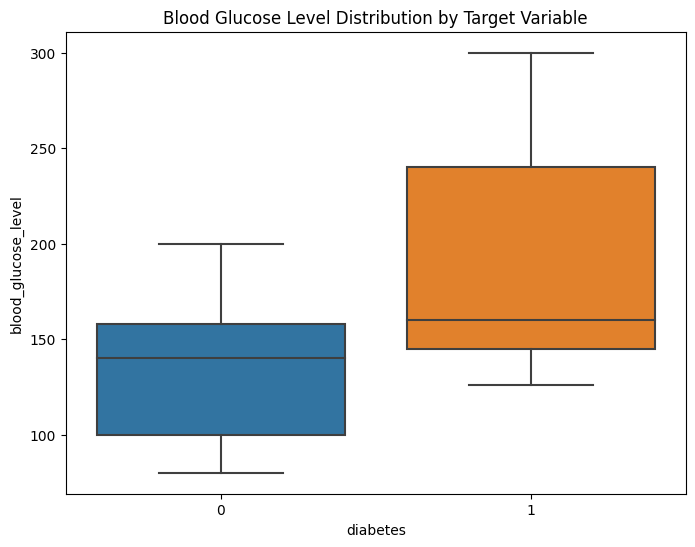

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=target_column, y='blood_glucose_level', data=pandas_df)
plt.title("Blood Glucose Level Distribution by Target Variable")
plt.show()


# Visualization of HbA1c Level Distribution by Target Variable

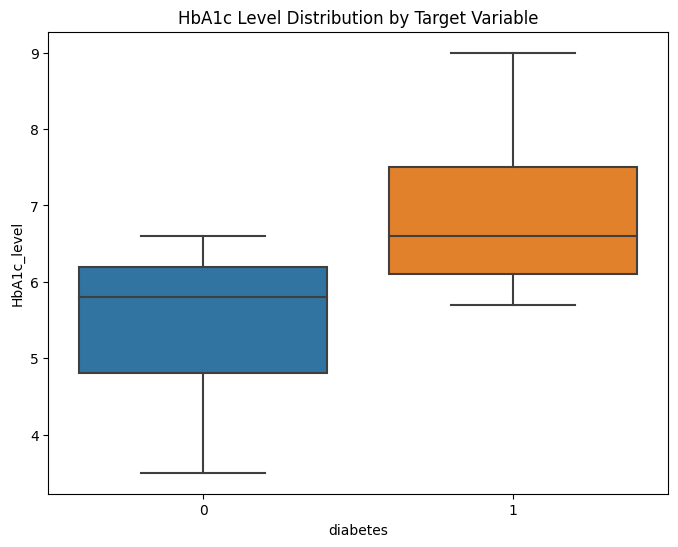

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=target_column, y='HbA1c_level', data=pandas_df)
plt.title("HbA1c Level Distribution by Target Variable")
plt.show()


# Checking unique values in the 'smoking_history' column

In [ ]:
unique_smoking_history = preprocessed_data.select('smoking_history').distinct().rdd.flatMap(lambda x: x).collect()
print("Unique Smoking History Values:", unique_smoking_history)

Unique Smoking History Values: ['not current', 'former', 'No Info', 'current', 'never', 'ever']


# Visualization of Blood Glucose Level vs. BMI Scatter Plot

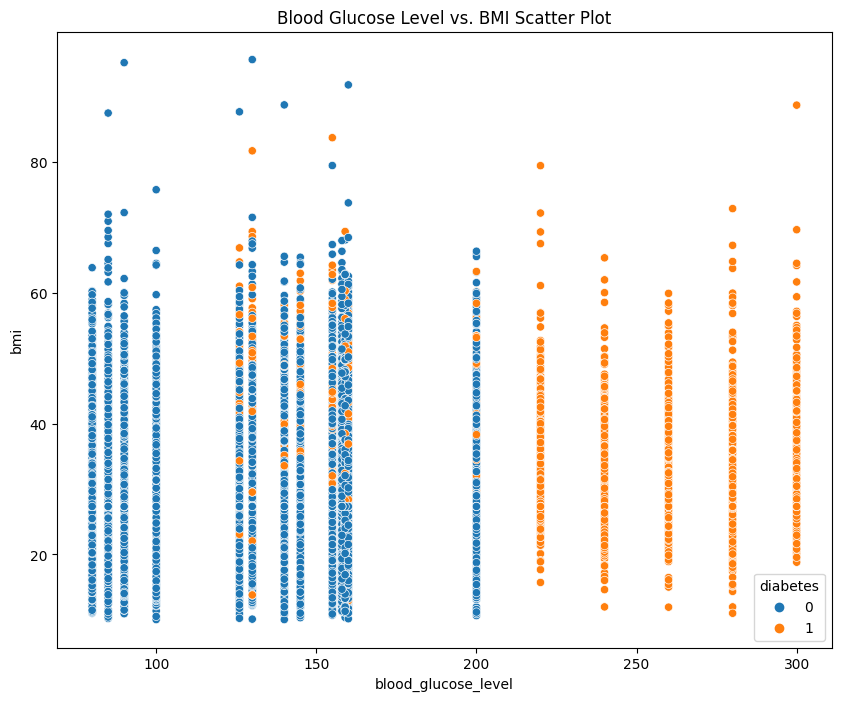

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='blood_glucose_level', y='bmi', hue=target_column, data=pandas_df)
plt.title("Blood Glucose Level vs. BMI Scatter Plot")
plt.show()


# Visualization of Blood Glucose Level vs. HbA1c Level Scatter Plot with Target Variable

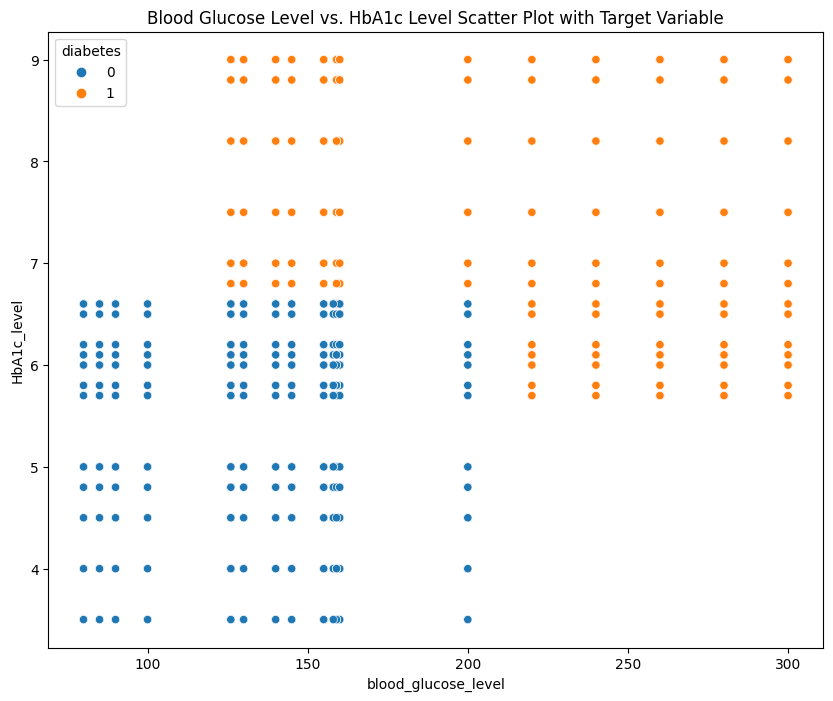

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='blood_glucose_level', y='HbA1c_level', hue=target_column, data=pandas_df)
plt.title("Blood Glucose Level vs. HbA1c Level Scatter Plot with Target Variable")
plt.show()


# Visualization of Distribution of BMI by Hypertension Status

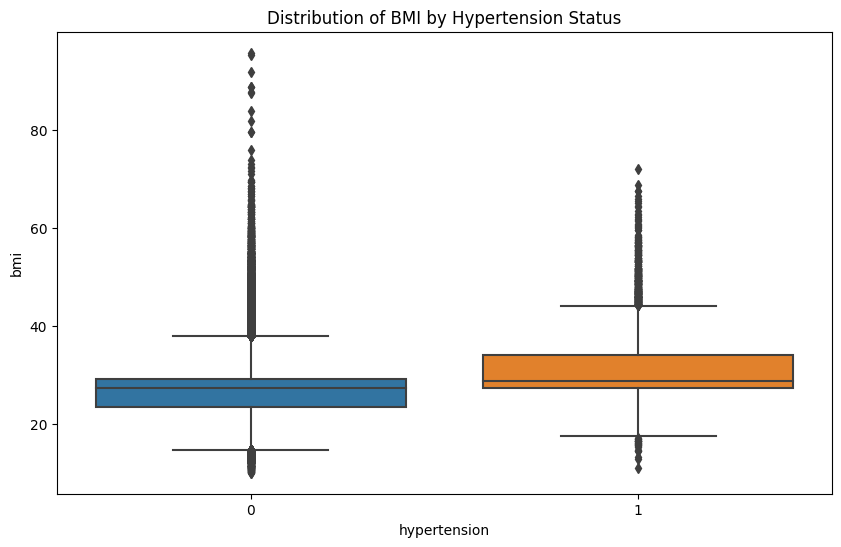

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='hypertension', y='bmi', data=pandas_df)
plt.title("Distribution of BMI by Hypertension Status")
plt.show()


# Implementing Machine Learning Models

## Train test spliting

In [ ]:
train_data, test_data = preprocessed_data.randomSplit([0.8, 0.2], seed=42)

#Creating random forest, decision tree, Gradient-Boosted Tree classifier models

In [ ]:
from pyspark.ml.classification import LogisticRegression
target_column = 'diabetes'
# Random Forest Classifier
rf = RandomForestClassifier(labelCol=target_column, featuresCol='features', numTrees=60)
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target_column, featuresCol='features')
# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol=target_column, featuresCol='features', maxIter=10)
# Building the parameter grid for the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .build())

## Fiting the models

In [ ]:
rf_model = rf.fit(train_data)
dt_model = dt.fit(train_data)
gbt_model = gbt.fit(train_data)


## Evaluation on Random Forest Model

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf_predictions = rf_model.transform(test_data)
rf_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName='accuracy')
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.9725857007811334


## Evaluation on Decision Tree Model

In [ ]:
dt_predictions = dt_model.transform(test_data)
dt_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.9725857007811334


## Evaluation on Gradient-Boosted Tree Model

In [ ]:
gbt_predictions = gbt_model.transform(test_data)
gbt_evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName='accuracy')
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Tree Accuracy: {gbt_accuracy}")

Gradient-Boosted Tree Accuracy: 0.9725857007811334


##Showing prediction for GBT Model

In [ ]:
gbt_predictions = gbt_model.transform(test_data)
# Selecting relevant columns for display
result_df = gbt_predictions.select('features', 'diabetes', 'prediction', 'probability').toPandas()
# Displaying the Pandas DataFrame
result_df

,features,diabetes,prediction,probability
0,"(0.08, 0.0, 0.0, 12.5, 4.5, 155.0, 1.0, 0.0, 1...",0,0.0,"[0.9318105754672763, 0.0681894245327237]"
1,"(0.08, 0.0, 0.0, 13.03, 6.2, 158.0, 1.0, 0.0, ...",0,0.0,"[0.9296606962340034, 0.07033930376599662]"
2,"(0.08, 0.0, 0.0, 13.39, 6.1, 90.0, 1.0, 0.0, 1...",0,0.0,"[0.9315134882700242, 0.06848651172997577]"
3,"(0.08, 0.0, 0.0, 27.32, 4.5, 160.0, 1.0, 0.0, ...",0,0.0,"[0.9318105754672763, 0.0681894245327237]"
4,"(0.16, 0.0, 0.0, 12.3, 5.8, 140.0, 1.0, 0.0, 1...",0,0.0,"[0.9296606962340034, 0.07033930376599662]"
...,...,...,...,...
20094,"[80.0, 1.0, 1.0, 27.32, 7.5, 159.0, 0.0, 1.0, ...",1,1.0,"[0.0658778243472172, 0.9341221756527828]"
20095,"[80.0, 1.0, 1.0, 27.83, 4.0, 160.0, 0.0, 1.0, ...",0,0.0,"[0.935286624183633, 0.06471337581636705]"
20096,"(10.0, 0.0, 0.0, 14.09, 5.0, 140.0, 0.0, 0.0, ...",0,0.0,"[0.9318105754672763, 0.0681894245327237]"
20097,"(18.0, 0.0, 0.0, 30.19, 6.1, 90.0, 0.0, 0.0, 0...",0,0.0,"[0.9303120593750214, 0.06968794062497863]"


##Showing prediction for DT model

In [ ]:
dt_predictions = dt_model.transform(test_data)
# Selecting relevant columns for display
result_df = dt_predictions.select('features', 'diabetes', 'prediction', 'probability').toPandas()
# Displaying the Pandas DataFrame
result_df

,features,diabetes,prediction,probability
0,"(0.08, 0.0, 0.0, 12.5, 4.5, 155.0, 1.0, 0.0, 1...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
1,"(0.08, 0.0, 0.0, 13.03, 6.2, 158.0, 1.0, 0.0, ...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
2,"(0.08, 0.0, 0.0, 13.39, 6.1, 90.0, 1.0, 0.0, 1...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
3,"(0.08, 0.0, 0.0, 27.32, 4.5, 160.0, 1.0, 0.0, ...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
4,"(0.16, 0.0, 0.0, 12.3, 5.8, 140.0, 1.0, 0.0, 1...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
...,...,...,...,...
20094,"[80.0, 1.0, 1.0, 27.32, 7.5, 159.0, 0.0, 1.0, ...",1,1.0,"[0.0, 1.0]"
20095,"[80.0, 1.0, 1.0, 27.83, 4.0, 160.0, 0.0, 1.0, ...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
20096,"(10.0, 0.0, 0.0, 14.09, 5.0, 140.0, 0.0, 0.0, ...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"
20097,"(18.0, 0.0, 0.0, 30.19, 6.1, 90.0, 0.0, 0.0, 0...",0,0.0,"[0.9699816864400032, 0.030018313559996814]"


## Showing prediction for Random Forest model

In [ ]:
rf_predictions = rf_model.transform(test_data)
# Selecting relevant columns for display
result_df = rf_predictions.select('features', 'diabetes', 'prediction', 'probability').toPandas()
# Displaying the Pandas DataFrame
result_df

,features,diabetes,prediction,probability
0,"(0.08, 0.0, 0.0, 12.5, 4.5, 155.0, 1.0, 0.0, 1...",0,0.0,"[0.9803205631192111, 0.019679436880788787]"
1,"(0.08, 0.0, 0.0, 13.03, 6.2, 158.0, 1.0, 0.0, ...",0,0.0,"[0.9772987049279631, 0.022701295072036835]"
2,"(0.08, 0.0, 0.0, 13.39, 6.1, 90.0, 1.0, 0.0, 1...",0,0.0,"[0.9778314936328426, 0.022168506367157375]"
3,"(0.08, 0.0, 0.0, 27.32, 4.5, 160.0, 1.0, 0.0, ...",0,0.0,"[0.9803205631192111, 0.019679436880788787]"
4,"(0.16, 0.0, 0.0, 12.3, 5.8, 140.0, 1.0, 0.0, 1...",0,0.0,"[0.9772987049279631, 0.022701295072036835]"
...,...,...,...,...
20094,"[80.0, 1.0, 1.0, 27.32, 7.5, 159.0, 0.0, 1.0, ...",1,1.0,"[0.06748646720011481, 0.9325135327998851]"
20095,"[80.0, 1.0, 1.0, 27.83, 4.0, 160.0, 0.0, 1.0, ...",0,0.0,"[0.9166474497166294, 0.08335255028337067]"
20096,"(10.0, 0.0, 0.0, 14.09, 5.0, 140.0, 0.0, 0.0, ...",0,0.0,"[0.9797195918631137, 0.020280408136886224]"
20097,"(18.0, 0.0, 0.0, 30.19, 6.1, 90.0, 0.0, 0.0, 0...",0,0.0,"[0.9749443935218918, 0.02505560647810823]"
